In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import sys
import json
import pprint

import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from matplotlib import gridspec
import pprint

detector_path = '..'
sys.path.append(detector_path)

from sleep.mass import KEY_EEG, KEY_PAGES, KEY_ID, KEY_MARKS
from sleep.data_ops import seq2inter, inter2seq, seq2inter_with_pages
from sleep.mass import MASS
from evaluation import data_manipulation
from sleep import data_ops
from sleep import postprocessing
from utils import param_keys
from evaluation import metrics

SEED = 123

%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
def get_border_size(my_p):
    border_duration = my_p[param_keys.BORDER_DURATION]
    fs = my_p[param_keys.FS]
    border_size = fs * border_duration
    return border_size


def get_page_size(my_p):
    page_duration = my_p[param_keys.PAGE_DURATION]
    fs = my_p[param_keys.FS]
    page_size = fs * page_duration
    return page_size


def prepare_labels(y, params):
    """Ensures that label data has the proper shape."""
    time_stride = 8
    border_size = get_border_size(params)
    page_size = get_page_size(params)
    crop_size = page_size + 2 * border_size
    if y.shape[1] == crop_size:
        # We need to remove borders and downsampling for val labels.
        y = y[:, border_size:-border_size:time_stride]
    return y

Dataset mass with 15 patients.
Train size: 11. Test size: 4
Train subjects: 
 [1, 3, 5, 7, 9, 10, 11, 14, 17, 18, 19]
Test subjects: 
 [2, 6, 12, 13]
Loading from checkpoint
Loaded
Restoring from ../results/predictions/v1_bn_fixed_files_trainINTA
Loading training set and splitting
Split IDs: Total 11 -- Training 8
Training set IDs: [1, 9, 10, 14, 17, 18, 7, 3]
Validation set IDs: [11, 19, 5]
Loading testing
Testing set IDs: [2, 6, 12, 13]
Getting ID 1, 745 N2 pages, Expert 1
Getting ID 9, 739 N2 pages, Expert 1
Getting ID 10, 696 N2 pages, Expert 1
Getting ID 14, 730 N2 pages, Expert 1
Getting ID 17, 797 N2 pages, Expert 1
Getting ID 18, 735 N2 pages, Expert 1
Getting ID 7, 694 N2 pages, Expert 1
Getting ID 3, 496 N2 pages, Expert 1
Getting ID 1, 745 N2 pages
Getting ID 9, 739 N2 pages
Getting ID 10, 696 N2 pages
Getting ID 14, 730 N2 pages
Getting ID 17, 797 N2 pages
Getting ID 18, 735 N2 pages
Getting ID 7, 694 N2 pages
Getting ID 3, 496 N2 pages
Getting ID 11, 638 N2 pages, Expert 1

../evaluation/metrics.py:74: RuntimeWarning: invalid value encountered in double_scalars
  f1_score = 2 * precision * recall / (precision + recall)


BE train stats
BE val stats
BE test stats
Train Mean F1 score: 0.0644
Val Mean F1 score: nan
Test Mean F1 score: 0.0845


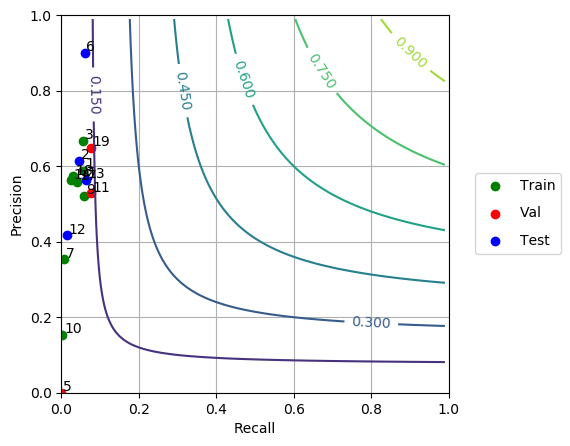

In [14]:
thr = 0.995

results_dir = os.path.join('..', 'results')

# ckpt_folder = 'predictions/v1_bn_fixed_files'
ckpt_folder = 'predictions/v1_bn_fixed_files_trainINTA'

ckpt_path = os.path.join(results_dir, ckpt_folder)

# Load data
dataset = MASS(load_checkpoint=True)

params = param_keys.default_params.copy()

print('Restoring from %s' % ckpt_path)

# Get training set ids
print('Loading training set and splitting')
all_train_ids = dataset.train_ids
# Split to form validation set
train_ids, val_ids = data_manipulation.split_ids_list(
    all_train_ids, seed=SEED)
print('Training set IDs:', train_ids)
print('Validation set IDs:', val_ids)

# Get test data
print('Loading testing')
test_ids = dataset.test_ids
print('Testing set IDs:', test_ids)

# Get data for predictions
augmented_page = False
which_expert = 1

border_size = get_border_size(params)
x_train, y_train = dataset.get_subset_data(
    train_ids, augmented_page=augmented_page, border_size=border_size,
    which_expert=which_expert, verbose=True)
pages_train = dataset.get_subset_pages(train_ids, verbose=True)

x_val, y_val = dataset.get_subset_data(
    val_ids, augmented_page=augmented_page, border_size=border_size,
    which_expert=which_expert, verbose=True)
pages_val = dataset.get_subset_pages(val_ids, verbose=True)

x_test, y_test = dataset.get_subset_data(
    test_ids, augmented_page=augmented_page, border_size=border_size,
    which_expert=which_expert, verbose=True)
pages_test = dataset.get_subset_pages(test_ids, verbose=True)

y_train = [prepare_labels(y, params) for y in y_train]
y_val = [prepare_labels(y, params) for y in y_val]
y_test = [prepare_labels(y, params) for y in y_test]

# We keep each patient separate, to see variation of performance
# between individuals
# save_dir = os.path.join(results_dir, 'predictions', ckpt_folder)
save_dir = os.path.join(results_dir, ckpt_folder)
y_pred_train = np.load(os.path.join(save_dir, 'y_pred_train.npy'), allow_pickle=True)
y_pred_val = np.load(os.path.join(save_dir, 'y_pred_val.npy'), allow_pickle=True)
y_pred_test = np.load(os.path.join(save_dir, 'y_pred_test.npy'), allow_pickle=True)

# Keep only class 1 probability
y_pred_train = [y[..., 1] for y in y_pred_train]
y_pred_val = [y[..., 1] for y in y_pred_val]
y_pred_test = [y[..., 1] for y in y_pred_test]

print('Predictions Loaded')

# Threshold to binarize


y_pred_train = [(y >= thr).astype(np.int32) for y in y_pred_train]
y_pred_val = [(y >= thr).astype(np.int32) for y in y_pred_val]
y_pred_test = [(y >= thr).astype(np.int32) for y in y_pred_test]


# Now we need to concatenate the pages and transform to intervals
y_train = [data_ops.seq2inter_with_pages(y, pages) for y, pages in zip(y_train, pages_train)]
y_pred_train = [data_ops.seq2inter_with_pages(y, pages) for y, pages in zip(y_pred_train, pages_train)]

y_val = [data_ops.seq2inter_with_pages(y, pages) for y, pages in zip(y_val, pages_val)]
y_pred_val = [data_ops.seq2inter_with_pages(y, pages) for y, pages in zip(y_pred_val, pages_val)]

y_test = [data_ops.seq2inter_with_pages(y, pages) for y, pages in zip(y_test, pages_test)]
y_pred_test = [data_ops.seq2inter_with_pages(y, pages) for y, pages in zip(y_pred_test, pages_test)]


fs_effect = int(params[param_keys.FS] / 8)


def post_process(marks, fs, delta_combine=0.3, min_duration=0.2, max_duration=4.0):
    marks = postprocessing.combine_close_marks(marks, fs, delta_combine)
    marks = postprocessing.filter_duration_marks(marks, fs, min_duration, max_duration)
    return marks


y_pred_train = [post_process(y, fs_effect) for y in y_pred_train]
y_pred_val = [post_process(y, fs_effect) for y in y_pred_val]
y_pred_test = [post_process(y, fs_effect) for y in y_pred_test]


be_train = [metrics.by_event_confusion(y, y_pred, iou_thr=0.3) for y, y_pred in zip(y_train, y_pred_train)]
be_val = [metrics.by_event_confusion(y, y_pred, iou_thr=0.3) for y, y_pred in zip(y_val, y_pred_val)]
be_test = [metrics.by_event_confusion(y, y_pred, iou_thr=0.3) for y, y_pred in zip(y_test, y_pred_test)]

print('BE train stats')
# pprint.pprint(be_train)

print('BE val stats')
# pprint.pprint(be_val)

print('BE test stats')
# pprint.pprint(be_test)

print('Train Mean F1 score: %1.4f' % np.mean([m['f1_score'] for m in be_train]))
print('Val Mean F1 score: %1.4f' % np.mean([m['f1_score'] for m in be_val]))
print('Test Mean F1 score: %1.4f' % np.mean([m['f1_score'] for m in be_test]))


# ---- Plot PR curve

fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=100)
text_space = 0.005
# Training results
for i, stats in enumerate(be_train):
    if i==0:
        ax.scatter(stats['recall'], stats['precision'], c='g', label='Train')
    else:
        ax.scatter(stats['recall'], stats['precision'], c='g')
    ax.annotate(train_ids[i], (stats['recall']+text_space, stats['precision']+text_space))
    
# Validation results
for i, stats in enumerate(be_val):
    if i==0:
        ax.scatter(stats['recall'], stats['precision'], c='r', label='Val')
    else:
        ax.scatter(stats['recall'], stats['precision'], c='r')
    ax.annotate(val_ids[i], (stats['recall']+text_space, stats['precision']+text_space))
    
# Testing results
for i, stats in enumerate(be_test):
    if i==0:
        ax.scatter(stats['recall'], stats['precision'], c='b', label='Test')
    else:
        ax.scatter(stats['recall'], stats['precision'], c='b')
    ax.annotate(test_ids[i], (stats['recall']+text_space, stats['precision']+text_space))
    

delta = 0.01 
x_ = np.arange(1, 100) * delta 
y_ = np.arange(1, 100) * delta 
X, Y = np.meshgrid(x_, y_)
Z = 2 * X * Y / (X + Y)

CS = ax.contour(X, Y, Z)
ax.clabel(CS, inline=1, fontsize=10)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.grid()
plt.legend(loc='lower left', bbox_to_anchor=(1.05, 0.35), labelspacing=1)
plt.show()

### F1 vs IoU

In [ ]:
# Test set performance F1 vs IoU
iou_array = np.arange(1, 10) * 0.1
print(iou_array)
f1_list = []
prec_list = []
rec_list = []
for iou_thr in iou_array:
    print(iou_thr)
    # be_train = [metrics.by_event_confusion(y, y_pred, iou_thr=0.3) for y, y_pred in zip(y_train, y_pred_train)]
    # be_val = [metrics.by_event_confusion(y, y_pred, iou_thr=0.3) for y, y_pred in zip(y_val, y_pred_val)]
    be_test = [metrics.by_event_confusion(y, y_pred, iou_thr=iou_thr) for y, y_pred in zip(y_test, y_pred_test)]
    mean_f1 = np.mean([m['f1_score'] for m in be_test])
    mean_prec = np.mean([m['precision'] for m in be_test])
    mean_rec = np.mean([m['recall'] for m in be_test])
    f1_list.append(mean_f1)
    prec_list.append(mean_prec)
    rec_list.append(mean_rec)
print('Done')

print('IoU')
pprint.pprint(iou_array)
print('')
print('Precision')
pprint.pprint(prec_list)
print('')
print('Recall')
pprint.pprint(rec_list)
print('')
print('F1score')
pprint.pprint(f1_list)

In [ ]:
to_save = np.stack([iou_array, f1_list], axis=1)
np.savetxt("f1_january_model_run%d.csv" % n_try, to_save, delimiter=",")

In [ ]:
fig = plt.figure(figsize=(4, 4), dpi=100)
plt.plot(iou_array, f1_list, color='k', linewidth=2, markersize=12, marker='.')
plt.title('Performance on test set (ensemble of 4 runs)', fontsize=10)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.yticks([0.1*i for i in range(1, 10)])
plt.xticks([0.1*i for i in range(1, 10)])
plt.xlabel('Overlap threshold')
plt.ylabel('F1-score')
plt.grid()
plt.show()

### Comparison

In [ ]:
folder = 'comparison_data'

# Chambon
convnet_data = np.loadtxt(os.path.join(folder, 'Convnet.csv'), delimiter=',')

# Expert
expert_data_mean = np.loadtxt(os.path.join(folder, 'MeanExpert.csv'), delimiter=',')
expert_data_std = np.loadtxt(os.path.join(folder, 'UpperExpert.csv'), delimiter=',')
expert_data_std[:, 1] = expert_data_std[:, 1] - expert_data_mean[:, 1]

# Proposed model
filename = 'f1_january_model_run%d.csv'
model_data = []
for n_try in [0, 1, 2, 3]:
    tmp_data = np.loadtxt(os.path.join(folder, filename % n_try), delimiter=',')
    model_data.append(tmp_data)
model_data = np.stack(model_data, axis=0)
model_data_mean = np.mean(model_data, axis=0)
model_data_mean[:, 0] = np.around(model_data_mean[:, 0], decimals=1)
model_data_std = np.std(model_data, axis=0)
model_data_std[:, 0] = model_data_mean[:, 0]

# Ensemble model
model_data_ensemble = np.loadtxt(os.path.join(folder, 'f1_january_model_ensemble.csv'), delimiter=',')
model_data_ensemble[:, 0] = np.around(model_data_ensemble[:, 0], decimals=1)

# --hardcoding:
model_data_ensemble[:, 1] = np.array(f1_list)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(9, 4), dpi=100)

# Complete plot
ax[0].plot(expert_data_mean[:, 0], expert_data_mean[:, 1], linewidth=2, markersize=12, marker='.', label='Expert Performance')
ax[0].fill_between(
    expert_data_mean[:, 0], 
    expert_data_mean[:, 1]-expert_data_std[:, 1], 
    expert_data_mean[:, 1]+expert_data_std[:, 1], 
    alpha=0.3)

# ax[0].plot(model_data_mean[:, 0], model_data_mean[:, 1], linewidth=2, markersize=12, marker='.', label='Proposed Model')
ax[0].plot(model_data_ensemble[:, 0], model_data_ensemble[:, 1], linewidth=2, markersize=12, marker='.', label='Proposed Model')
ax[0].plot(convnet_data[:, 0], convnet_data[:, 1], linewidth=2, markersize=12, marker='.', label='Chambon et al.')
ax[0].set_title('Detection Performance', fontsize=10)
# ax[0].axis('square')
ax[0].set_xlim([0, 1])
ax[0].set_ylim([0, 1])
ax[0].set_yticks([0.1*i for i in range(1, 10)])
ax[0].set_xticks([0.1*i for i in range(1, 10)])
ax[0].set_xlabel('Threshold for IoU')
ax[0].set_ylabel('F1-score')
# ax[0].legend(loc='lower left')
ax[0].grid()

# Zoom plot
ax[1].plot(expert_data_mean[:, 0], expert_data_mean[:, 1], linewidth=2, markersize=12, marker='.', 
           label='Expert Performance\nPrivate Database\nWarby et al. 2014')
ax[1].fill_between(
    expert_data_mean[:, 0], 
    expert_data_mean[:, 1]-expert_data_std[:, 1], 
    expert_data_mean[:, 1]+expert_data_std[:, 1], 
    alpha=0.3)

# ax[0].plot(model_data_mean[:, 0], model_data_mean[:, 1], linewidth=2, markersize=12, marker='.', label='Proposed Model')
ax[1].plot(model_data_ensemble[:, 0], model_data_ensemble[:, 1], linewidth=2, markersize=12, marker='.', 
           label='Proposed Model\nMASS Database')
ax[1].plot(convnet_data[:, 0], convnet_data[:, 1], linewidth=2, markersize=12, marker='.', 
           label='ConvNet\nMASS Database\nChambon et al. 2018')
ax[1].set_title('Detection Performance (ZOOM)', fontsize=10)
# ax[1].axis('square')
ax[1].set_xlim([0.05, 0.75])
ax[1].set_ylim([0.6, 0.85])
# ax[1].set_yticks([0.1*i for i in range(1, 10)])
# ax[1].set_xticks([0.1*i for i in range(1, 10)])
ax[1].set_xlabel('Threshold for IoU')
ax[1].set_ylabel('F1-score')
ax[1].legend(loc='lower left', bbox_to_anchor=(1.05, 0.15), labelspacing=3)
ax[1].grid()

plt.show()

In [ ]:
np.savetxt("f1_vs_iou_expert_mean.csv", expert_data_mean, delimiter=",")
np.savetxt("f1_vs_iou_expert_std.csv", expert_data_std, delimiter=",")